In [1]:
# Import libraries
from ngsolve import *
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [31]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))

# V = H1(mesh,order=1,dirichlet=".*")
order = 1 # 3 maybe gives solutions in C1.
V = H1(mesh,order=order,dirichlet="bottom|left|top")

u = V.TrialFunction()
v = V.TestFunction()
 
# anisotropic diffusion tensor
k11 = 1
k12 = 0
k21 = 0
k22 = 1
kappa = CoefficientFunction(((k11, k12), (k21, k22)), dims=(2, 2))
# Draw(kappa[1,1],mesh)

f = LinearForm(V)
f += 1.0*v*dx 
f += -1*v*ds("right")  # Neumann BCs

a = BilinearForm(V, symmetric=True)
a += (kappa * grad(u)) * grad(v) * dx

a.Assemble()
f.Assemble()

gfu = GridFunction(V)
gfu.vec.data = a.mat.Inverse(V.FreeDofs(),inverse="sparsecholesky") * f.vec
from ngsolve.webgui import Draw
Draw(gfu)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

Errors: [4.76214789e-02 4.24582373e-02 2.86598165e-02 2.31296128e-02
 1.96677433e-02 1.45409488e-02 9.86775877e-03 7.04248239e-03
 4.63748405e-03 2.76242287e-03 1.39778996e-03 5.21477731e-04
 7.69323435e-05]
Estimated order of convergence: [1.39146719 4.37204411 2.17026657 1.47905715 2.45272952 2.7603482
 2.06366284 2.137114   2.12993127 2.11502844 2.06256747 2.01641492]


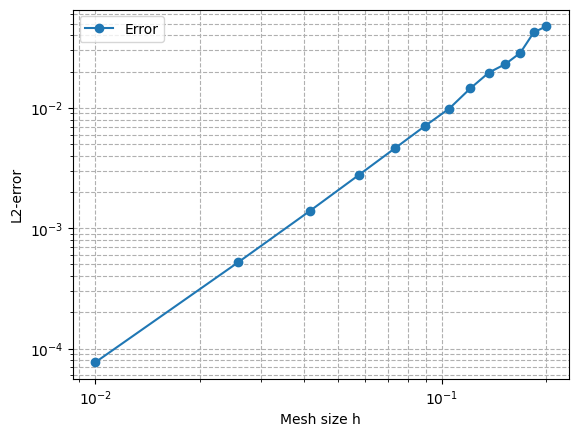

In [3]:
def poisson(u_man,kappa_matrix,order=1,maxh=0.04):
    mesh = Mesh(unit_square.GenerateMesh(maxh=maxh))

    # V = H1(mesh,order=1,dirichlet=".*")
    V = H1(mesh,order=order,dirichlet=[1,2,3,4])

    u = V.TrialFunction()
    v = V.TestFunction()
    
    # anisotropic diffusion tensor
    k11 = kappa_matrix[0, 0]
    k12 = kappa_matrix[0, 1]        
    k21 = kappa_matrix[1, 0]
    k22 = kappa_matrix[1, 1]
    kappa = CoefficientFunction(((k11, k12), (k21, k22)), dims=(2, 2))
    # Draw(kappa[1,1],mesh)

    f_man = -((k11*u_man.Diff(x) + k12*u_man.Diff(y)).Diff(x)+
            (k21*u_man.Diff(x) + k22*u_man.Diff(y)).Diff(y))

    f = LinearForm(V)
    f += f_man * v * dx

    a = BilinearForm(V, symmetric=True)
    a += (kappa * grad(u)) * grad(v) * dx

    a.Assemble()
    f.Assemble()

    gfu = GridFunction(V)
    gfu.vec.data = a.mat.Inverse(V.FreeDofs(),inverse="sparsecholesky") * f.vec
    return sqrt (Integrate ( (gfu-u_man)*(gfu-u_man), mesh))

kappa_matrix = np.array([[1, 0], [0, 1]])
u_man = 16*x*(1-x)*y*(1-y)

hmax = np.linspace(0.2,0.01,13)
errors = np.zeros(len(hmax))

for i,h in enumerate(hmax):
    errors[i] = poisson(u_man,kappa_matrix,order=1,maxh=h)
    
# Compute convergence order
orders = np.zeros(len(hmax)-1)
for i in range(len(hmax)-1):
    orders[i] = np.log(errors[i]/errors[i+1]) / np.log(hmax[i]/hmax[i+1])

print("Errors:", errors)
print("Estimated order of c" \
"onvergence:", orders)

# Plot errors
plt.figure()
plt.loglog(hmax, errors, marker='o', label='Error')
plt.xlabel('Mesh size h')
plt.ylabel('L2-error')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()
